<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/resnet50_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import History 
from keras.models import Sequential
from tensorflow.keras import layers

from random import randint
import numpy as np
import os
from tqdm import tqdm

from skimage.io import imread
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Making the dataset:

In [ ]:
# read all the images first
x_train = []
WIDTH = 128
for i in range(1, 4): # changed to 3 classes
    base_dir = f'/content/drive/MyDrive/cancer_dataG/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        resized = cv2.resize(img, (WIDTH, WIDTH))
        x_train.append(resized)
X_train = np.array(x_train)
X_train.shape

100%|██████████| 250/250 [00:03<00:00, 72.21it/s] 


(750, 128, 128)

In [ ]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

## Labels to categorical

In [ ]:
from tensorflow.keras.utils import to_categorical

print(Y_train.shape)

Y_train =to_categorical(Y_train)

print(Y_train.shape)

(750,)
(750, 3)


## Normalize dataset:

In [ ]:
print('Maximum before: ', np.max(X_train))
print('Mean before: ', np.mean(X_train), end='\n\n')

X_train = X_train / 255

print('Maximum after: ', np.max(X_train))
print('Mean after: ', np.mean(X_train))

Maximum before:  255
Mean before:  44.361420817057294

Maximum after:  1.0
Mean after:  0.1739663561453224


## Splitting the data:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,
                                                    stratify=Y_train, 
                                                    test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(600, 128, 128)
(150, 128, 128)


In [ ]:
# Reshaping as per requirement

x_wanted_train = x_train.reshape(len(x_train), WIDTH, WIDTH, 1)
x_wanted_test = x_test.reshape(len(x_test), WIDTH, WIDTH, 1)

## Augmenting the data:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
datagen.fit(x_wanted_train)

# Model Work: 

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# Adding some extra layers before the input to deal with a single channel image
# resnet takes a 3 channel input
img_input = layers.Input(shape=(WIDTH, WIDTH, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

# Load model without classifier/fully connected layers
# the top 3 layers are the fully connected dense layers when we say include_top = False
# it means we don't want them, we only want the Convolutional layers
resnet_model = ResNet50(input_tensor=img_conc, weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()  #Trainable parameters will be 0

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['concatenate[0][0]']     

In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in resnet_model.layers:
    #if not layer.name.startswith('conv5_block3_3'):
    layer.trainable = False

## Creating the model:

In [ ]:
INPUT_SHAPE = (WIDTH, WIDTH)   

model = Sequential()
# to add the extra dimesion in the image
#model.add(layers.Reshape((WIDTH, WIDTH, 1), input_shape=INPUT_SHAPE))
# using the renset CNN with learned features, only learninf in con_5 block_3
model.add(resnet_model)
# flattening the multiple dimension output from the CNN
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(5000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(CLASSES, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 5000)              163845000 
                                                                 
 dense_1 (Dense)             (None, 1000)              5001000   
                                                                 
 dense_2 (Dense)             (None, 256)               256256    
                                                                 
 dense_3 (Dense)             (None, 3)                 7

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])

## Training the model

In [ ]:
from keras.callbacks import EarlyStopping
# instroducing early stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


history = model.fit(datagen.flow(x_wanted_train, y_train, batch_size=32,
         subset='training'),
         validation_data=(x_wanted_test, y_test),
        callbacks=[early_stopping_monitor],
#          steps_per_epoch=len(x_train) // 32, 
#         validation_steps = len(x_train) // 8,
        epochs=10)

Epoch 1/10
15/15 [==============================] - 61s 4s/step - loss: 24.6287 - accuracy: 0.4021 - val_loss: 1.1067 - val_accuracy: 0.3333
Epoch 2/10
15/15 [==============================] - 55s 4s/step - loss: 0.8756 - accuracy: 0.6625 - val_loss: 1.0870 - val_accuracy: 0.3800
Epoch 3/10
15/15 [==============================] - 55s 4s/step - loss: 0.5164 - accuracy: 0.7958 - val_loss: 2.2009 - val_accuracy: 0.3333
Epoch 4/10
15/15 [==============================] - 54s 4s/step - loss: 0.7024 - accuracy: 0.7729 - val_loss: 1.1821 - val_accuracy: 0.3333
Epoch 5/10
15/15 [==============================] - 55s 4s/step - loss: 0.3909 - accuracy: 0.9000 - val_loss: 1.0855 - val_accuracy: 0.4400
Epoch 6/10
15/15 [==============================] - 55s 4s/step - loss: 0.3031 - accuracy: 0.8896 - val_loss: 3.0511 - val_accuracy: 0.4400
Epoch 7/10
15/15 [==============================] - 54s 4s/step - loss: 0.3620 - accuracy: 0.8875 - val_loss: 1.5676 - val_accuracy: 0.4333
Epoch 8/10
15/15 [=

## Visualizing Results:

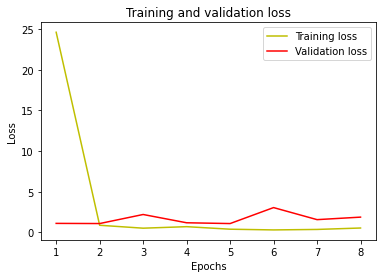

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

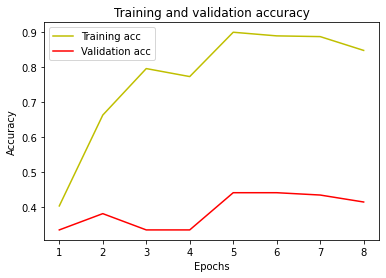

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Taking a prediction:

The prediction for this image is:  0
The actual label for this image is:  0


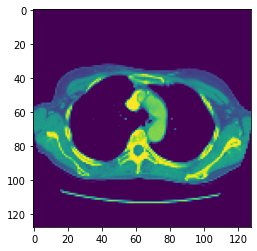

In [ ]:
n = 44  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y)

print("The prediction for this image is: ", np.argmax(model.predict(input_img)[0]))
print("The actual label for this image is: ", np.argmax(y_test[n]))

In [ ]:
y_test_org = np.argmax(y_test, axis=1)

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
def showconfusionmatrix(cm):
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

[[50  0  0]
 [50  0  0]
 [34  0 16]]


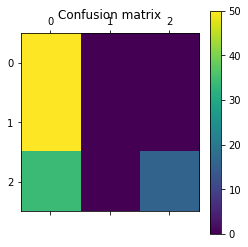

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_org, pred)
print (cm)

showconfusionmatrix(cm)